In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.filters.hp_filter import hpfilter

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Layer, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import random
import tensorflow as tf
import time

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [7]:
df = pd.read_csv('/content/drive/MyDrive/PLN_Timeseries/aa_442300170322_engineered.csv')
# df
# df['READ_DATE'] = pd.to_datetime(df['READ_DATE'])
# df.drop('READ_DATE_day', axis=1, inplace=True)
df

,READ_DATE,KWH_EXP,tavg,tmin,tmax,wdir,wspd,pres,Tavg,RH_avg,RR,ss,KWH_EXP_MA,KWH_EXP_ES,trend_ma,cycle_ma
0,2019-01-01,11.001903,25.7,24.8,30.2,44.0,6.4,1008.9,25.7,96.0,12.9,7.5,11.353501,10.727112,21.551561,-10.198060
1,2019-01-02,11.422662,26.0,24.1,29.2,21.0,5.4,1009.2,25.9,90.0,42.7,6.7,11.353501,11.692460,21.558516,-10.205016
2,2019-01-03,2.341671,24.6,24.0,27.3,340.0,4.1,1010.3,24.9,94.0,0.5,0.1,11.353501,9.640836,21.565472,-10.211971
3,2019-01-04,4.800008,26.2,23.0,29.8,340.0,6.9,1011.4,25.8,88.0,34.6,0.1,11.353501,5.073890,21.572427,-10.218927
4,2019-01-05,5.752651,26.9,23.6,30.2,284.0,6.3,1011.7,26.7,88.0,2.1,3.2,11.353501,4.003960,21.579383,-10.225882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1973,2024-05-27,2.381903,28.3,24.4,34.0,126.0,9.9,1009.9,28.7,73.0,0.0,10.4,30.750679,1.889256,33.642867,-2.892188
1974,2024-05-28,2.412923,28.2,24.1,33.9,125.0,8.0,1009.4,28.2,75.0,0.0,8.2,28.331286,3.427209,33.650026,-5.318740
1975,2024-05-29,2.564494,29.0,24.2,33.0,130.0,7.7,1009.1,29.0,77.0,0.0,10.7,25.749157,2.469251,33.657186,-7.908029
1976,2024-05-30,2.558021,29.7,25.0,35.0,106.0,7.8,1009.7,29.6,73.0,0.0,10.6,23.339417,0.867502,33.664345,-10.324929


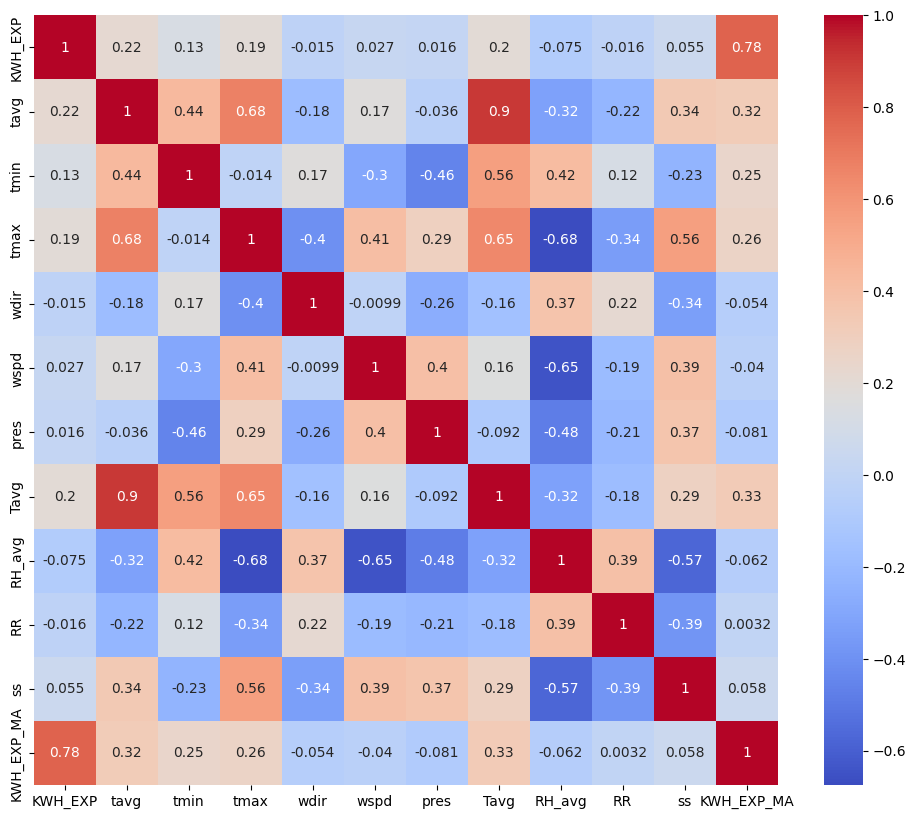

In [14]:
# correlation plot
corr = df.copy()
corr.drop(['READ_DATE', 'KWH_EXP_ES', 'trend_ma', 'cycle_ma'], axis=1, inplace=True)
corr = corr.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

In [15]:
df.columns

Index(['READ_DATE', 'KWH_EXP', 'tavg', 'tmin', 'tmax', 'wdir', 'wspd', 'pres',
       'Tavg', 'RH_avg', 'RR', 'ss', 'KWH_EXP_MA', 'KWH_EXP_ES', 'trend_ma',
       'cycle_ma'],
      dtype='object')

In [16]:
df.set_index('READ_DATE', inplace=True)

df.drop(['KWH_EXP', 'KWH_EXP_ES', 'trend_ma', 'cycle_ma'], axis=1, inplace=True)
df.columns

Index(['tavg', 'tmin', 'tmax', 'wdir', 'wspd', 'pres', 'Tavg', 'RH_avg', 'RR',
       'ss', 'KWH_EXP_MA'],
      dtype='object')

In [17]:
# split data train dan test. 3 tahun pertama untuk train, 2 tahun terakhir untuk test
"""
READ_DATE
2019-01-01	11.001903	25.7	24.8	30.2	44.0	6.4	1008.9
2019-01-02	11.422662	26.0	24.1	29.2	21.0	5.4	1009.2
2019-01-03	2.341671	24.6	24.0	27.3	340.0	4.1	1010.3
2019-01-04	4.800008	26.2	23.0	29.8	340.0	6.9	1011.4
2019-01-05	5.752651	26.9	23.6	30.2	284.0	6.3	1011.7
...	...	...	...	...	...	...	...
2024-05-27	2.381903	28.3	24.4	34.0	126.0	9.9	1009.9
2024-05-28	2.412923	28.2	24.1	33.9	125.0	8.0	1009.4
2024-05-29	2.564494	29.0	24.2	33.0	130.0	7.7	1009.1
# 2024-05-30	2.558021	29.7	25.0	35.0	106.0	7.8	1009.7
2024-05-31	2.457463	29.8	25.5	35.2	121.0	9.6	1010.4
"""
train = df.loc['2019-01-01':'2022-12-31']
test = df.loc['2023-01-01':'2024-05-24']
real_sim = df.loc['2024-05-25':'2024-05-31']

In [18]:
# Scale data
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

train_scaled_features = feature_scaler.fit_transform(train)
train_scaled_target = target_scaler.fit_transform(train[['KWH_EXP_MA']])
test_scaled_features = feature_scaler.transform(test)
test_scaled_target = target_scaler.transform(test[['KWH_EXP_MA']])

# train_scaled_features = feature_scaler.fit_transform(train)
# train_scaled_target = target_scaler.fit_transform(train[['KWH_EXP_ES']])
# test_scaled_features = feature_scaler.transform(test)
# test_scaled_target = target_scaler.transform(test[['KWH_EXP_ES']])


In [19]:
train_scaled_features

array([[-1.718197  ,  1.02028777, -1.55236723, ...,  0.76411145,
        -0.17024642, -0.8710234 ],
       [-1.43304526,  0.46910278, -2.13049838, ...,  3.41015117,
        -0.44476392, -0.8710234 ],
       [-2.76375338,  0.39036207, -3.22894758, ..., -0.33692522,
        -2.70953335, -0.8710234 ],
       ...,
       [-1.52809584,  0.54784349, -1.55236723, ...,  0.59540422,
        -0.03298767, -1.08460406],
       [-1.52809584,  0.39036207, -3.22894758, ..., -0.06166605,
        -2.05755427, -1.1374801 ],
       [-0.19738772,  1.02028777, -0.80079673, ...,  2.9750641 ,
        -2.74384803, -1.20411565]])

In [21]:
# # Daftar timestep yang akan diuji
timesteps_list = [1, 2, 3, 4, 5, 6, 7]

In [26]:
def plot_predictions(model, X_test_t, y_test_t, scaler, timesteps, model_name, real_sim, n_future=7):
    # Make predictions
    y_pred = model.predict(X_test_t)
    y_test_orig = target_scaler.inverse_transform(y_test_t.reshape(-1, 1))
    y_pred_orig = target_scaler.inverse_transform(y_pred)

    # Create DataFrame for Actual vs Predicted
    results_df = pd.DataFrame({
        'Actual': y_test_orig.flatten(),
        'Predicted': y_pred_orig.flatten()
    })

    # Save DataFrame to CSV with model name and timesteps
    file_name = f"{model_name}_timestep_{timesteps}_actual_vs_pred.csv"
    results_df.to_csv(file_name, index=False)
    print(f"Results saved to {file_name}")

    # Plot Actual vs Predicted
    plt.figure(figsize=(15, 8))
    plt.subplot(2, 1, 1)
    plt.plot(results_df['Actual'], label='Actual', alpha=0.8)
    plt.plot(results_df['Predicted'], label='Predicted', alpha=0.8)
    plt.title(f'Actual vs Predicted (Timesteps={timesteps})')
    plt.xlabel('Time')
    plt.ylabel('KWH_EXP')
    plt.legend()
    plt.grid(True)

    # Generate future predictions
    last_sequence = X_test_t[-1:]
    future_pred = []

    for _ in range(n_future):
        next_pred = model.predict(last_sequence)
        future_pred.append(next_pred[0])

        last_sequence = np.roll(last_sequence, -1, axis=1)
        last_sequence[0, -1] = next_pred[0]

    future_pred = target_scaler.inverse_transform(np.array(future_pred).reshape(-1, 1))

    # Combine test + real_sim and test + n_future predictions
    combined_actual = np.concatenate((y_test_orig.flatten(), real_sim['KWH_EXP_MA'].values))
    combined_predicted = np.concatenate((y_test_orig.flatten(), future_pred.flatten()))

    # Limit scope to the last part of the data
    scope_start = max(0, len(combined_actual) - (n_future + 28))
    scoped_actual = combined_actual[scope_start:]
    scoped_predicted = combined_predicted[scope_start:]

    # Plot Comparison
    plt.subplot(2, 1, 2)
    plt.plot(range(len(scoped_actual)), scoped_actual, label='Test + Real Sim', alpha=0.8)
    plt.plot(range(len(scoped_predicted)), scoped_predicted, label='Test + Predicted Future', alpha=0.8)
    plt.title('Comparison of Real Simulation vs Predicted Future (Zoomed In)')
    plt.xlabel('Time')
    plt.ylabel('KWH_EXP')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    mse = mean_squared_error(y_test_orig, y_pred_orig)
    r2 = r2_score(y_test_orig, y_pred_orig)
    mape = mean_absolute_percentage_error(y_test_orig, y_pred_orig)
    mae = mean_absolute_error(y_test_orig, y_pred_orig)
    print(f"\nMetrics for timesteps={timesteps}:")
    print(f"MSE: {mse:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"MAPE: {mape:.4f}")
    print(f"MAE: {mae:.4f}")



def train_and_plot_bilstm(X_train, y_train, X_test, y_test, timesteps, real_sim):
    def create_dataset(X, y, time_steps=1):
      Xs, ys = [], []
      for i in range(len(X) - time_steps):
          v = X[i:(i + time_steps)]
          Xs.append(v)
          ys.append(y[i + time_steps])
      return np.array(Xs), np.array(ys)

    X_train_t, y_train_t = create_dataset(X_train, y_train, timesteps)
    X_test_t, y_test_t = create_dataset(X_test, y_test, timesteps)

    model = Sequential([
        Input(shape=(timesteps, X_train.shape[1])),
        Bidirectional(LSTM(128, return_sequences=True)),
        Bidirectional(LSTM(64)),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        mode='min',
        verbose=1
    )

    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=0.001,
        verbose=1
    )

    model.fit(
        X_train_t,
        y_train_t,
        validation_split=0.1,
        epochs=50,
        batch_size=512,
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    plot_predictions(model, X_test_t, y_test_t, target_scaler, timesteps, model_name="bilstm", real_sim=real_sim, n_future=7)



Training model with selected features and timesteps = 1
Epoch 41: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step
Results saved to bilstm_timestep_1_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


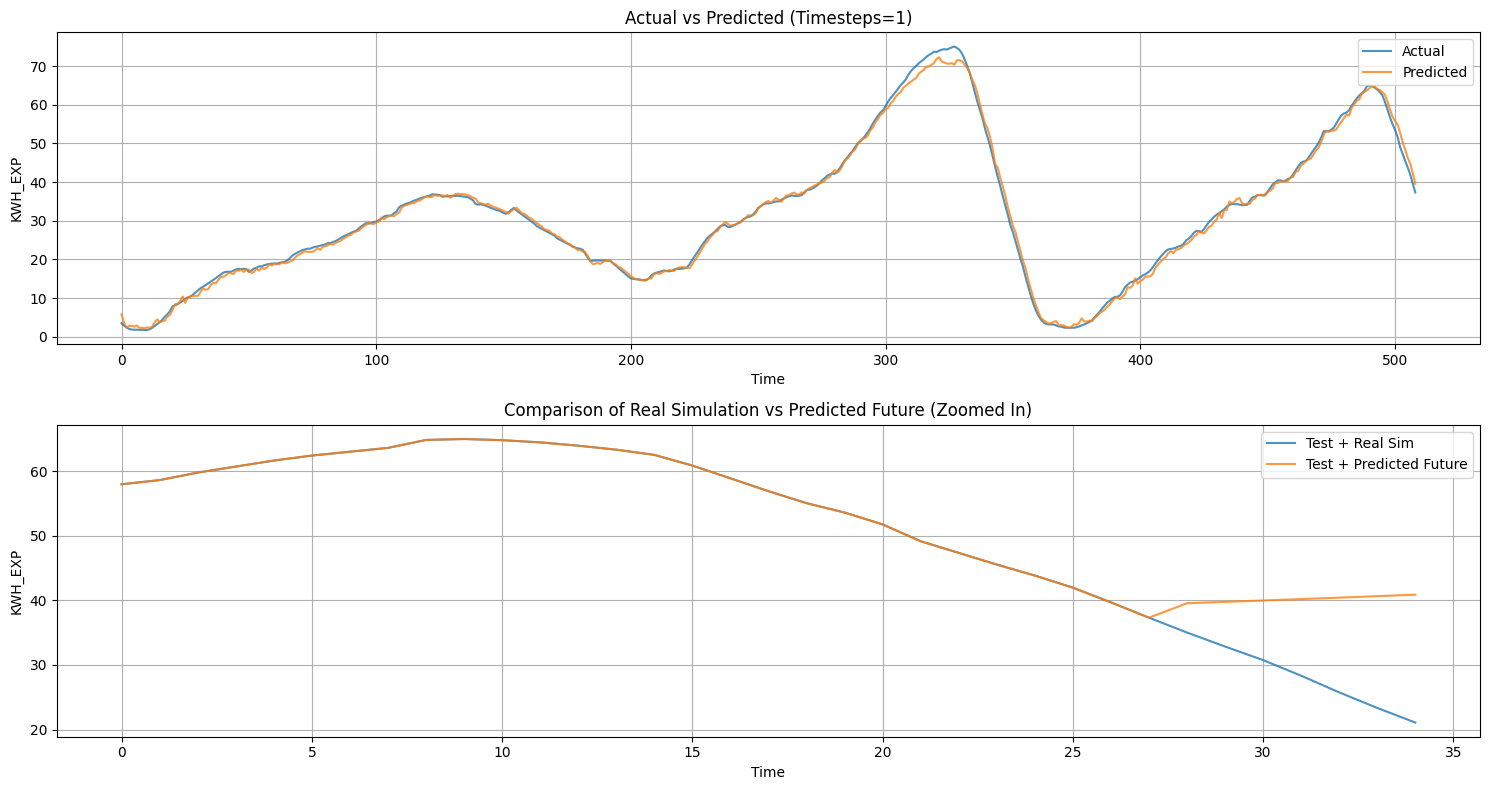


Metrics for timesteps=1:
MSE: 1.2190
R²: 0.9963
MAPE: 0.0458
MAE: 0.8101
Training time for timesteps = 1: 23.73 seconds

Training model with selected features and timesteps = 3
Epoch 19: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step
Results saved to bilstm_timestep_3_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


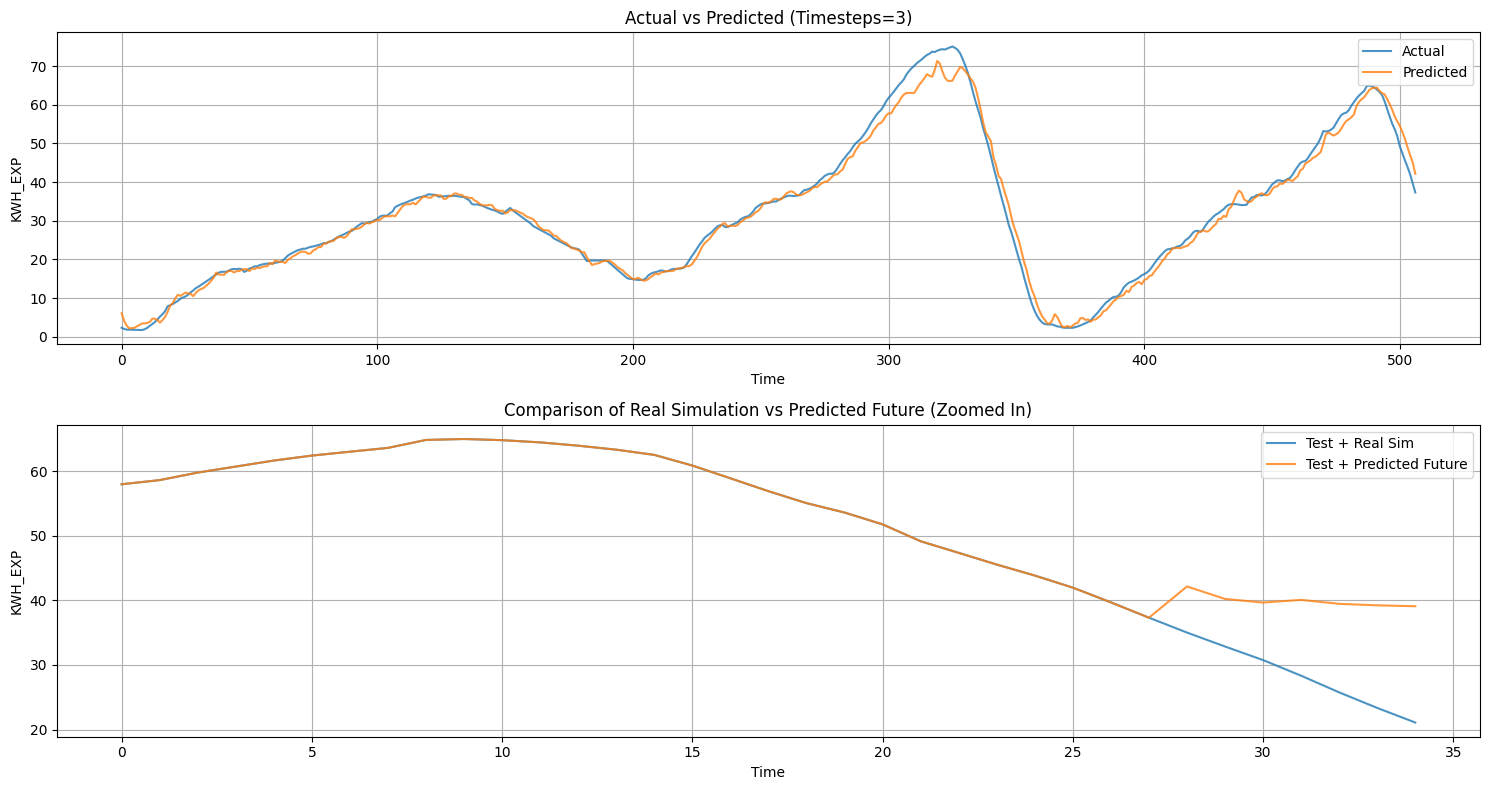


Metrics for timesteps=3:
MSE: 4.4795
R²: 0.9862
MAPE: 0.0786
MAE: 1.4724
Training time for timesteps = 3: 28.94 seconds

Training model with selected features and timesteps = 3
Epoch 24: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step
Results saved to bilstm_timestep_3_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


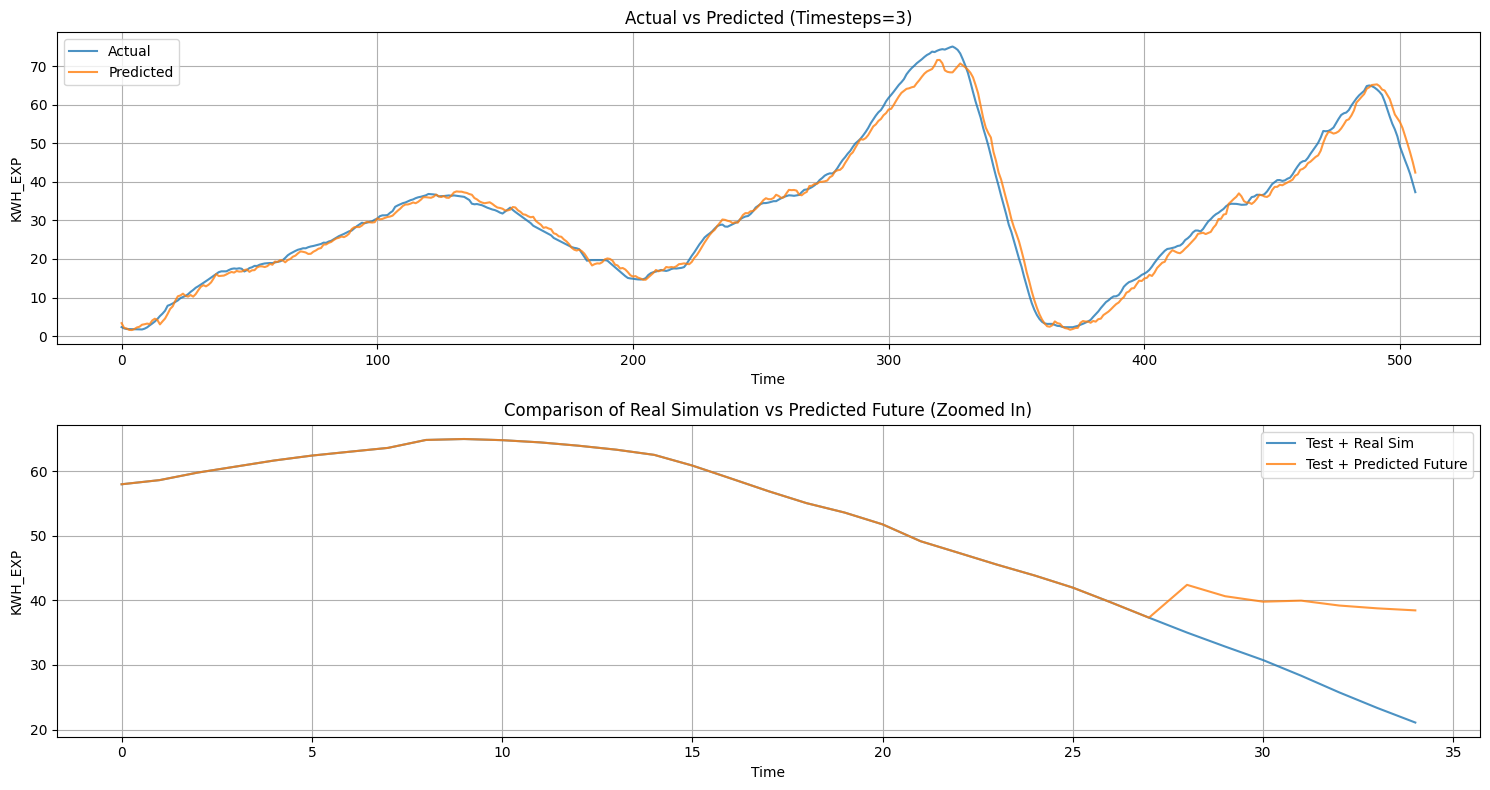


Metrics for timesteps=3:
MSE: 3.9633
R²: 0.9878
MAPE: 0.0685
MAE: 1.4923
Training time for timesteps = 3: 24.93 seconds

Training model with selected features and timesteps = 4
Epoch 9: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
Results saved to bilstm_timestep_4_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


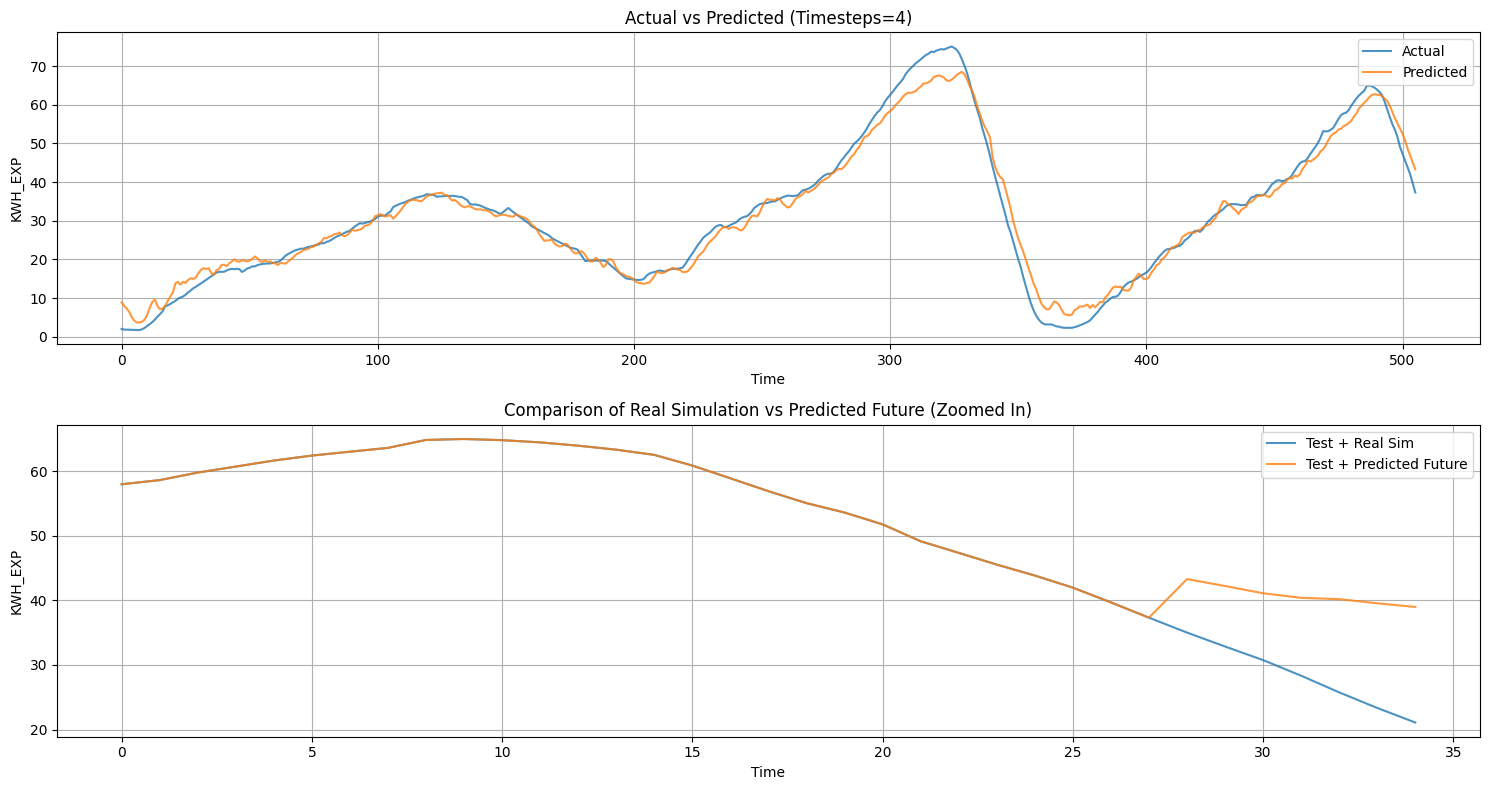


Metrics for timesteps=4:
MSE: 7.9492
R²: 0.9755
MAPE: 0.1822
MAE: 2.0960
Training time for timesteps = 4: 18.71 seconds

Training model with selected features and timesteps = 5
Epoch 17: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step
Results saved to bilstm_timestep_5_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


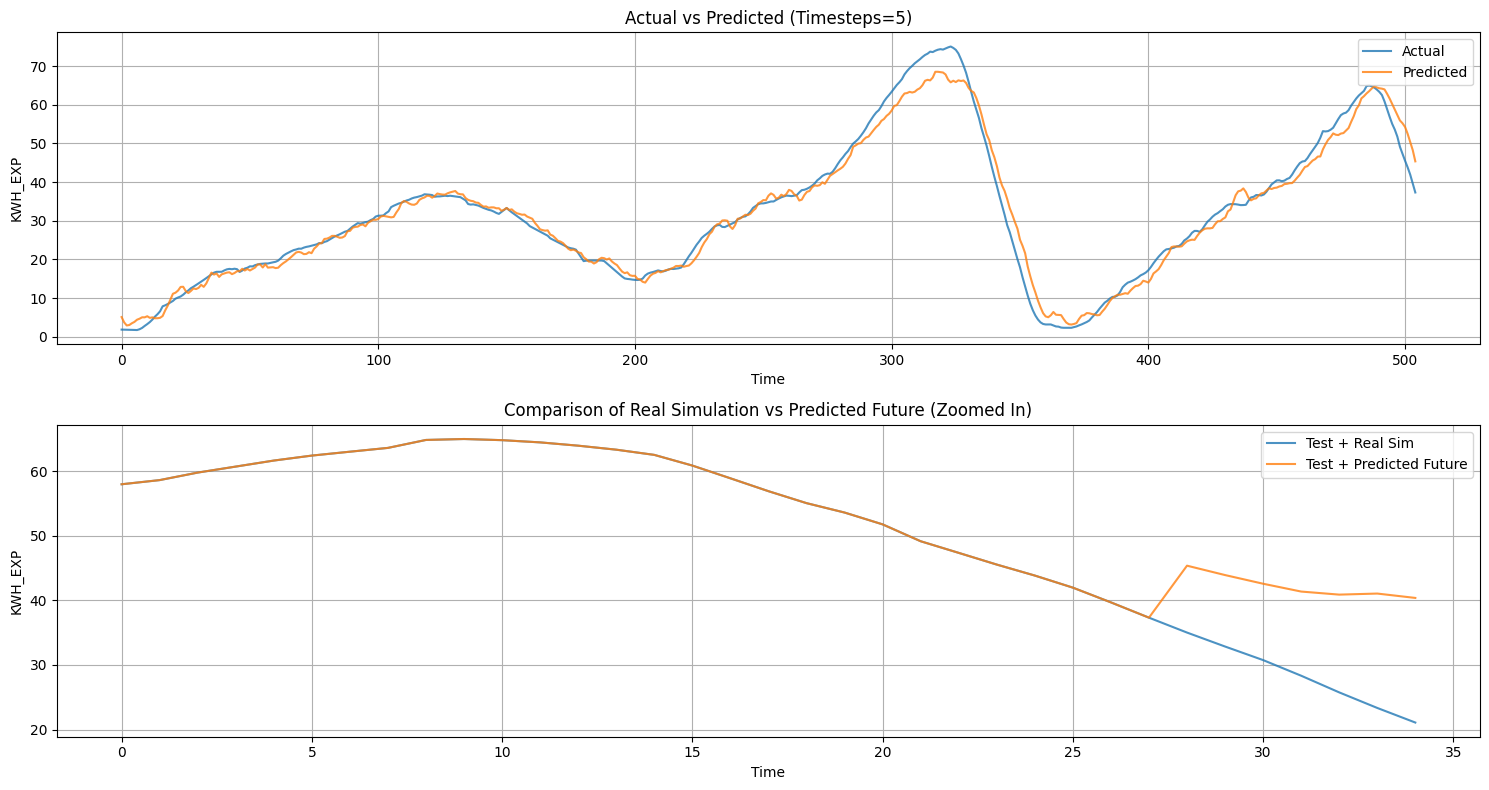


Metrics for timesteps=5:
MSE: 7.9562
R²: 0.9754
MAPE: 0.1201
MAE: 1.9995
Training time for timesteps = 5: 27.95 seconds

Training model with selected features and timesteps = 6
Epoch 15: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step
Results saved to bilstm_timestep_6_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


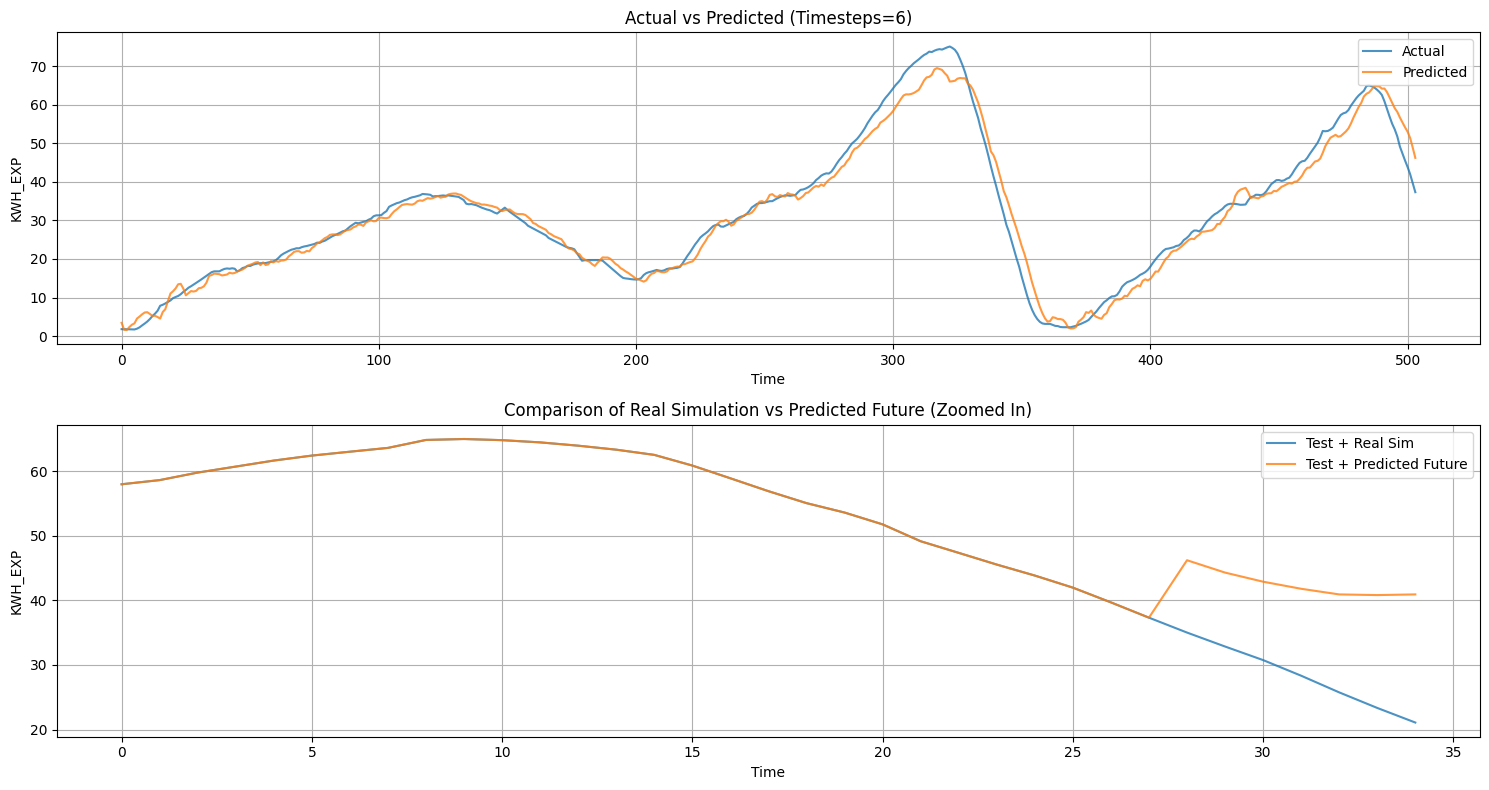


Metrics for timesteps=6:
MSE: 9.1602
R²: 0.9715
MAPE: 0.1142
MAE: 2.2135
Training time for timesteps = 6: 25.52 seconds

Training model with selected features and timesteps = 7
Epoch 20: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step
Results saved to bilstm_timestep_7_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


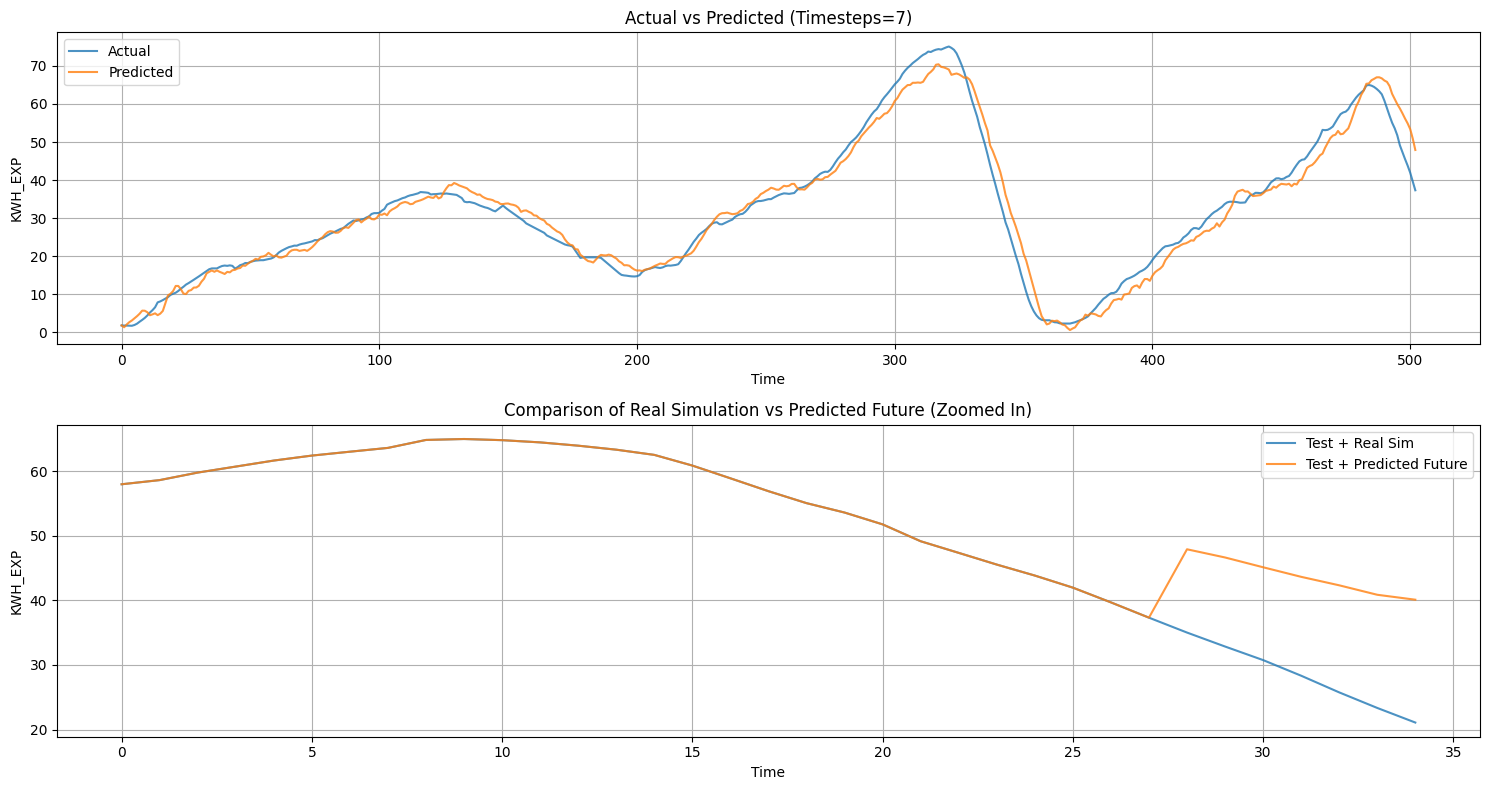


Metrics for timesteps=7:
MSE: 10.4940
R²: 0.9673
MAPE: 0.1133
MAE: 2.4791
Training time for timesteps = 7: 27.83 seconds
Total training execution time: 177.62 seconds


In [27]:
# Integrate with existing training scheme
total_training_start_time = time.time()
for ts in timesteps_list:

    print(f"\nTraining model with selected features and timesteps = {ts}")
    training_start_time = time.time()
    train_and_plot_bilstm(train_scaled_features, train_scaled_target.ravel(), test_scaled_features, test_scaled_target.ravel(), ts, real_sim)
    training_end_time = time.time()
    print(f"Training time for timesteps = {ts}: {training_end_time - training_start_time:.2f} seconds")

total_training_end_time = time.time()
print(f"Total training execution time: {total_training_end_time - total_training_start_time:.2f} seconds")

In [28]:
def train_and_plot_lstm(X_train, y_train, X_test, y_test, timesteps, real_sim):
    def create_dataset(X, y, time_steps=1):
      Xs, ys = [], []
      for i in range(len(X) - time_steps):
          v = X[i:(i + time_steps)]
          Xs.append(v)
          ys.append(y[i + time_steps])
      return np.array(Xs), np.array(ys)

    X_train_t, y_train_t = create_dataset(X_train, y_train, timesteps)
    X_test_t, y_test_t = create_dataset(X_test, y_test, timesteps)

    model = Sequential([
        Input(shape=(timesteps, X_train.shape[1])),
        LSTM(128, return_sequences=True),
        LSTM(64),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        mode='min',
        verbose=1
    )

    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=0.001,
        verbose=1
    )

    model.fit(
        X_train_t,
        y_train_t,
        validation_split=0.1,
        epochs=50,
        batch_size=512,
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    plot_predictions(model, X_test_t, y_test_t, target_scaler, timesteps, model_name="lstm", real_sim=real_sim, n_future=7)


In [29]:
# Daftar timestep yang akan diuji
timesteps_list = [1, 3, 3, 4, 5, 6, 7]


Training model with selected features and timesteps = 1
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Results saved to lstm_timestep_1_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


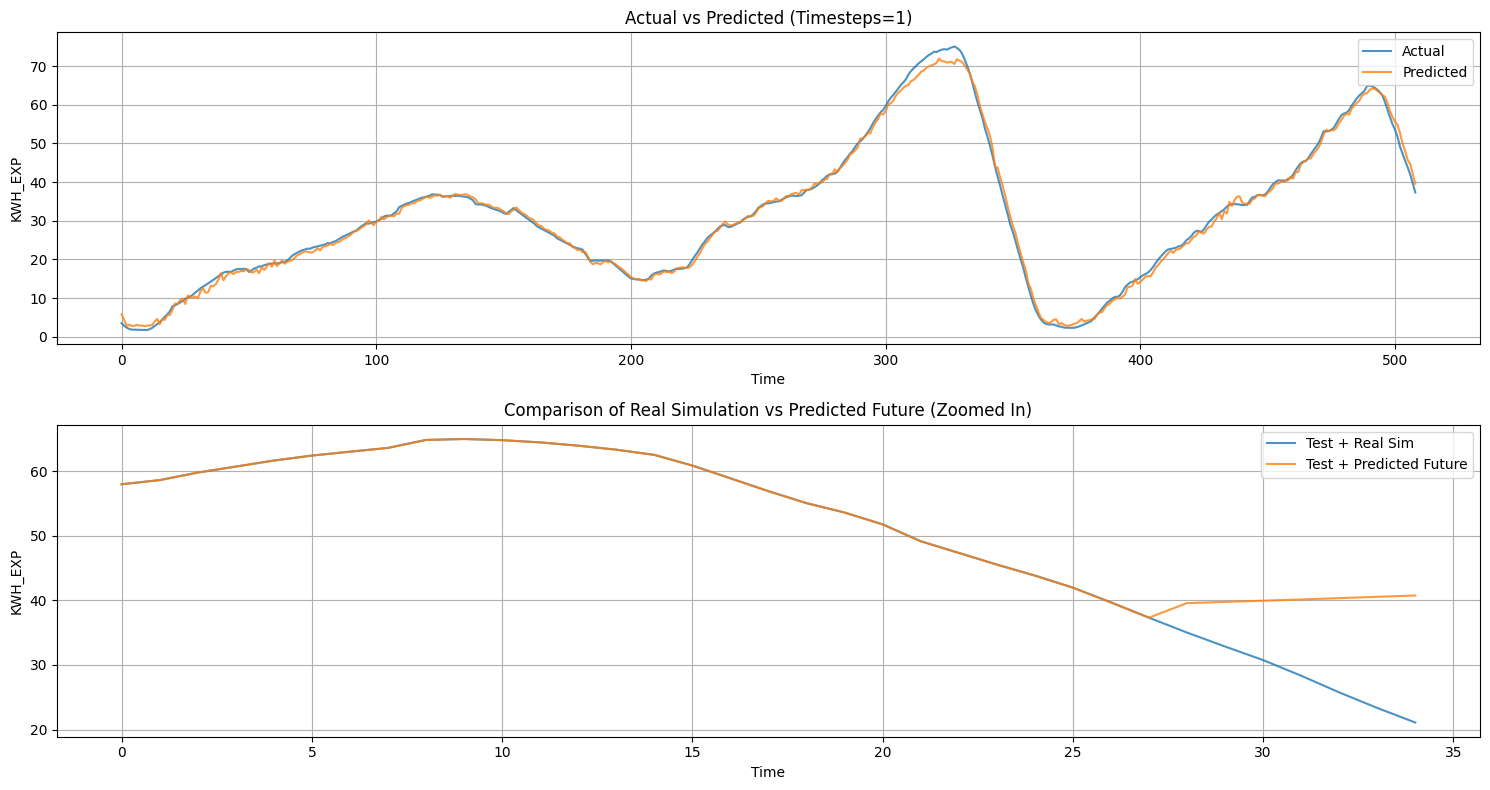


Metrics for timesteps=1:
MSE: 1.2602
R²: 0.9961
MAPE: 0.0556
MAE: 0.8454
Training time for timesteps = 1: 16.88 seconds

Training model with selected features and timesteps = 3
Epoch 23: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Results saved to lstm_timestep_3_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


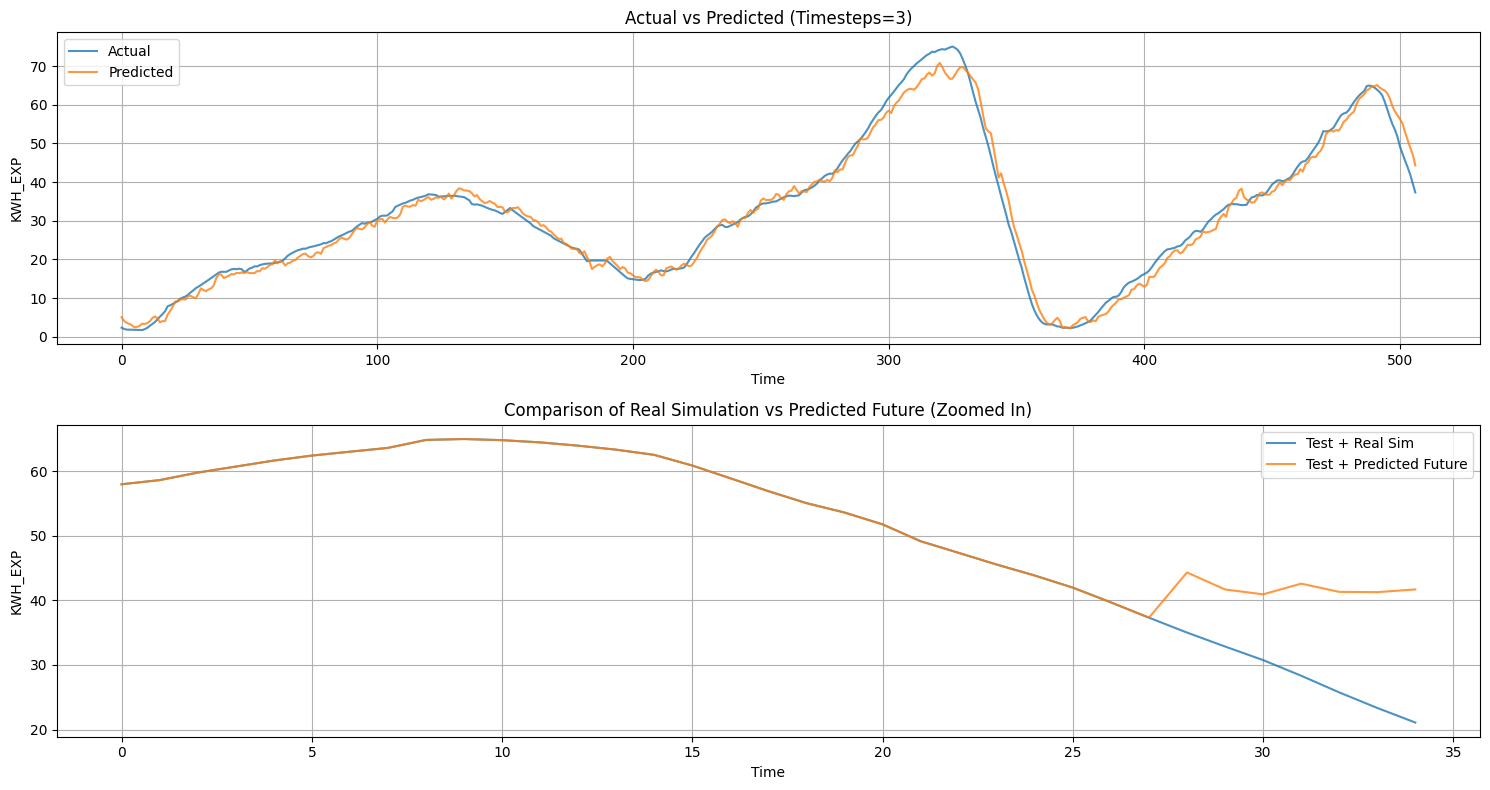


Metrics for timesteps=3:
MSE: 5.7019
R²: 0.9824
MAPE: 0.0954
MAE: 1.8135
Training time for timesteps = 3: 14.29 seconds

Training model with selected features and timesteps = 3
Epoch 29: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Results saved to lstm_timestep_3_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


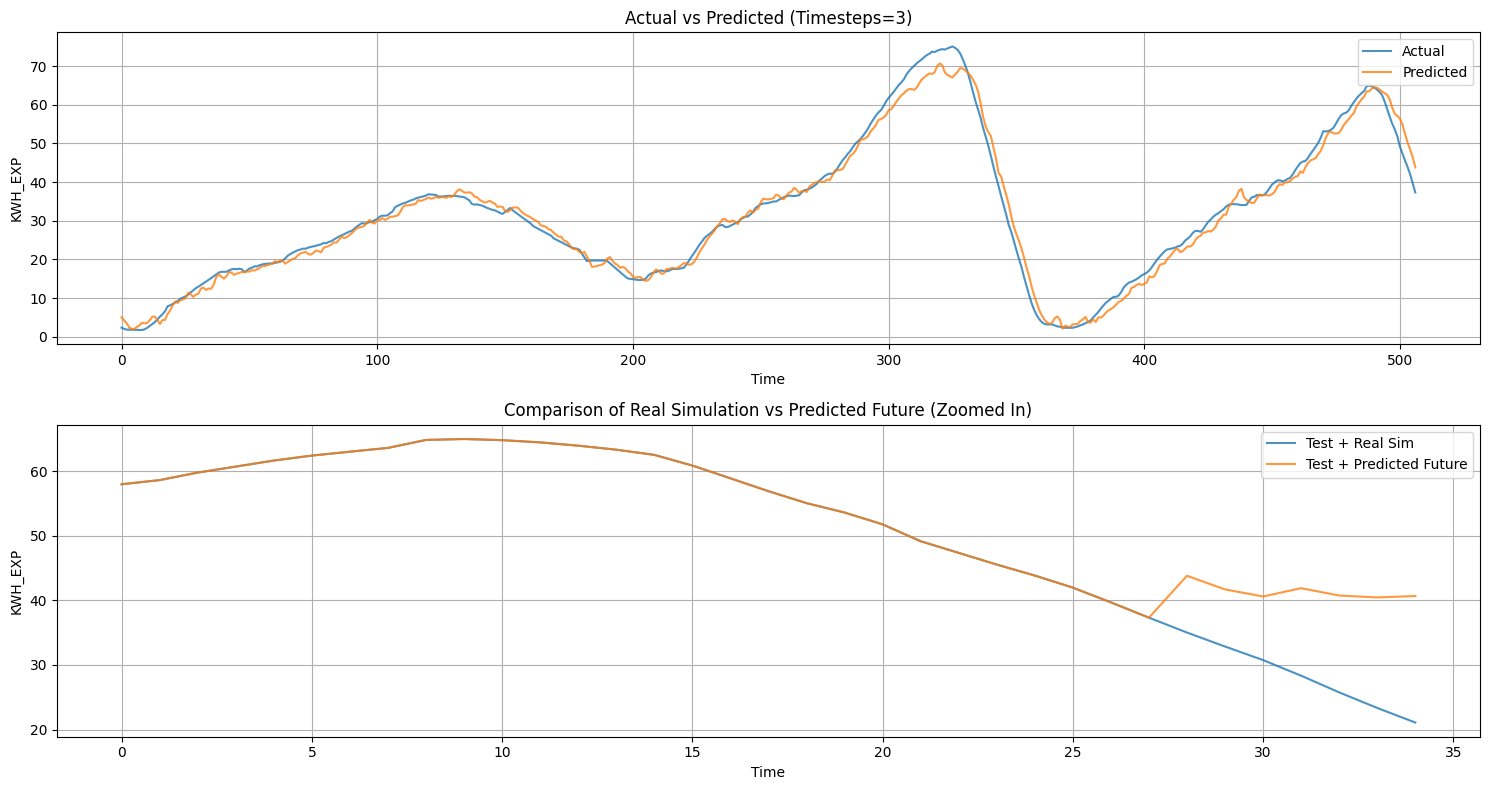


Metrics for timesteps=3:
MSE: 5.3596
R²: 0.9835
MAPE: 0.0924
MAE: 1.7576
Training time for timesteps = 3: 14.83 seconds

Training model with selected features and timesteps = 4
Epoch 26: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Results saved to lstm_timestep_4_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


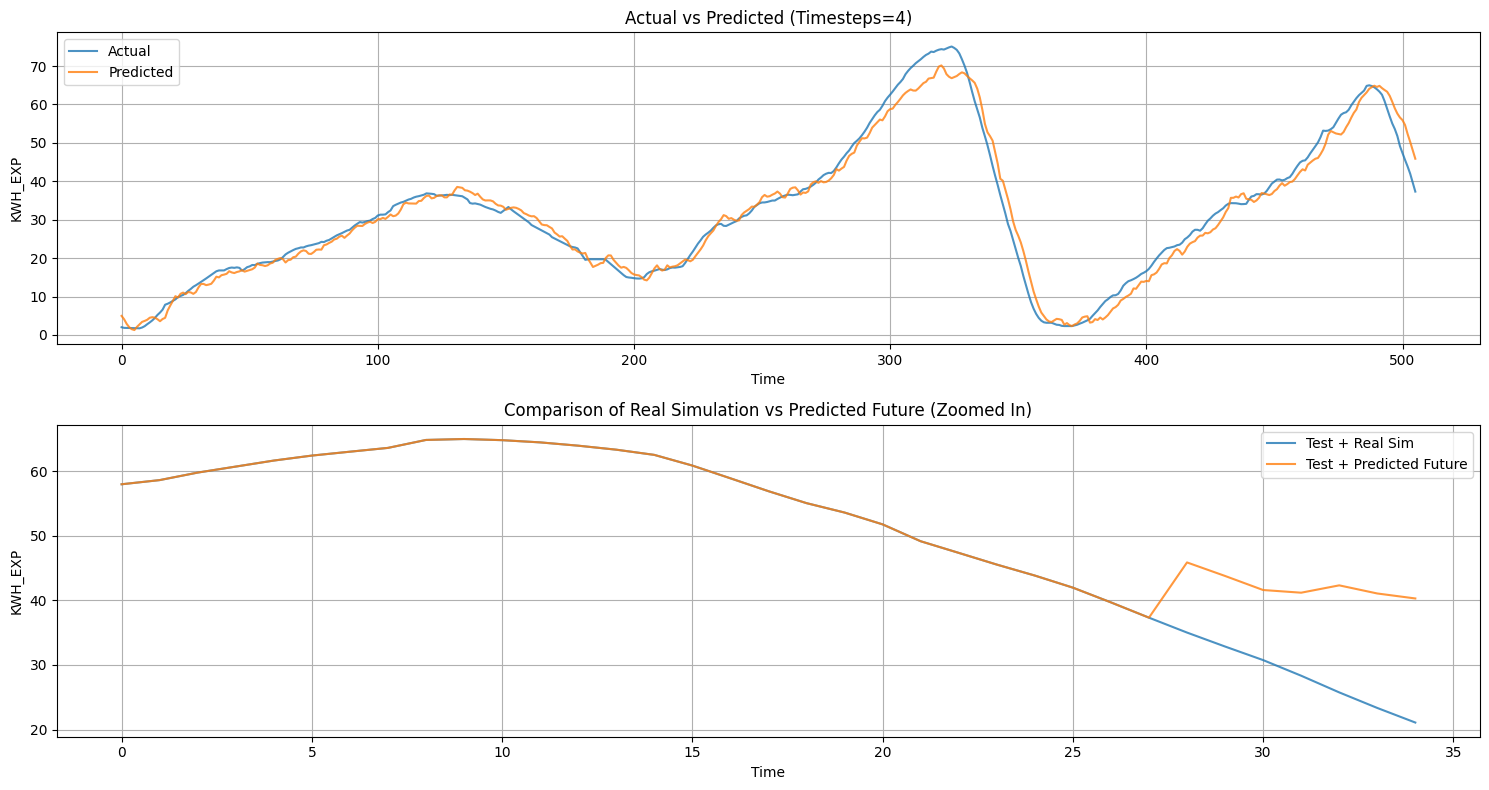


Metrics for timesteps=4:
MSE: 7.7345
R²: 0.9761
MAPE: 0.1030
MAE: 2.1209
Training time for timesteps = 4: 14.65 seconds

Training model with selected features and timesteps = 5
Epoch 27: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
Results saved to lstm_timestep_5_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


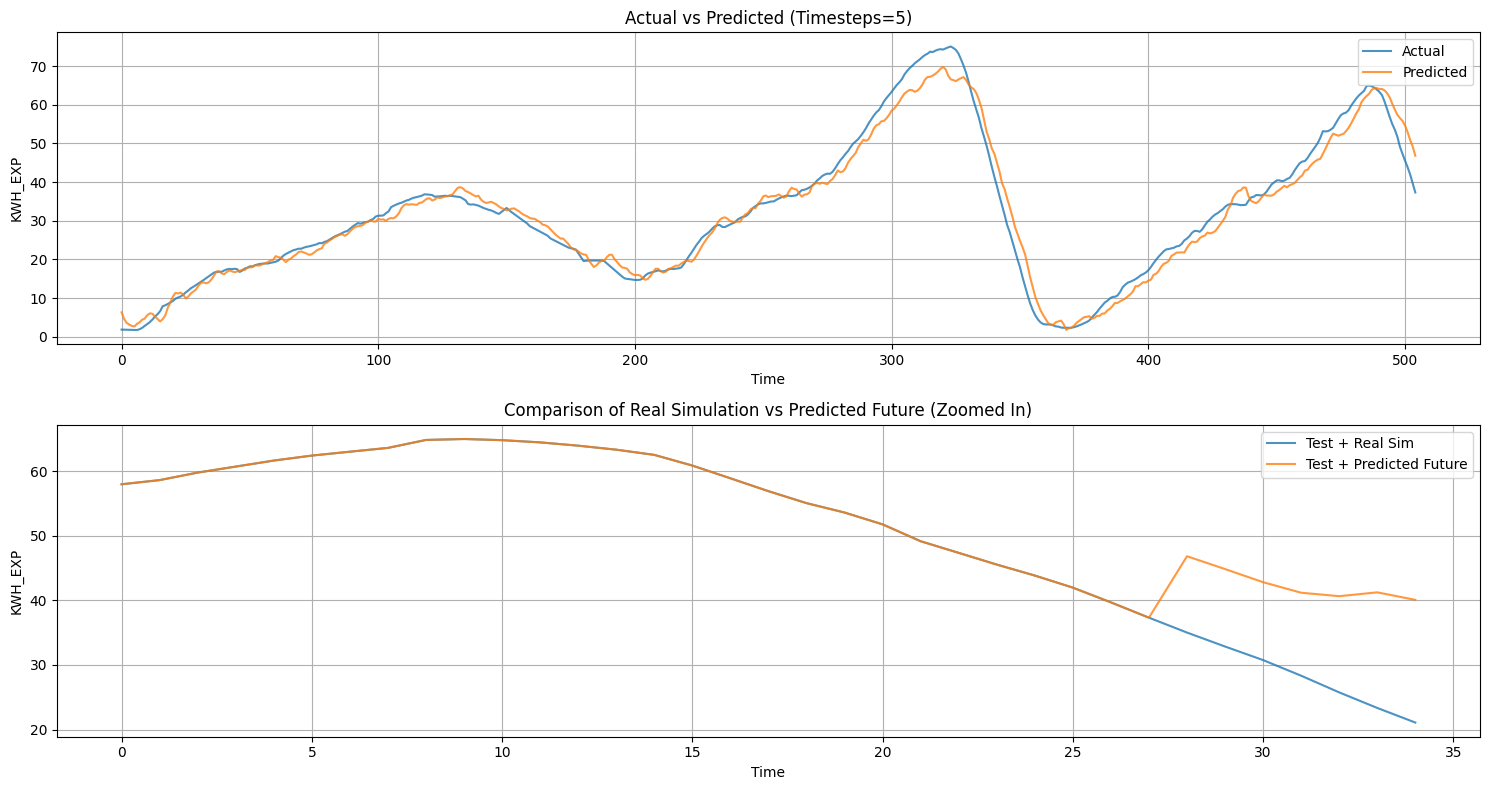


Metrics for timesteps=5:
MSE: 9.1480
R²: 0.9717
MAPE: 0.1163
MAE: 2.3002
Training time for timesteps = 5: 16.26 seconds

Training model with selected features and timesteps = 6
Epoch 23: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
Results saved to lstm_timestep_6_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


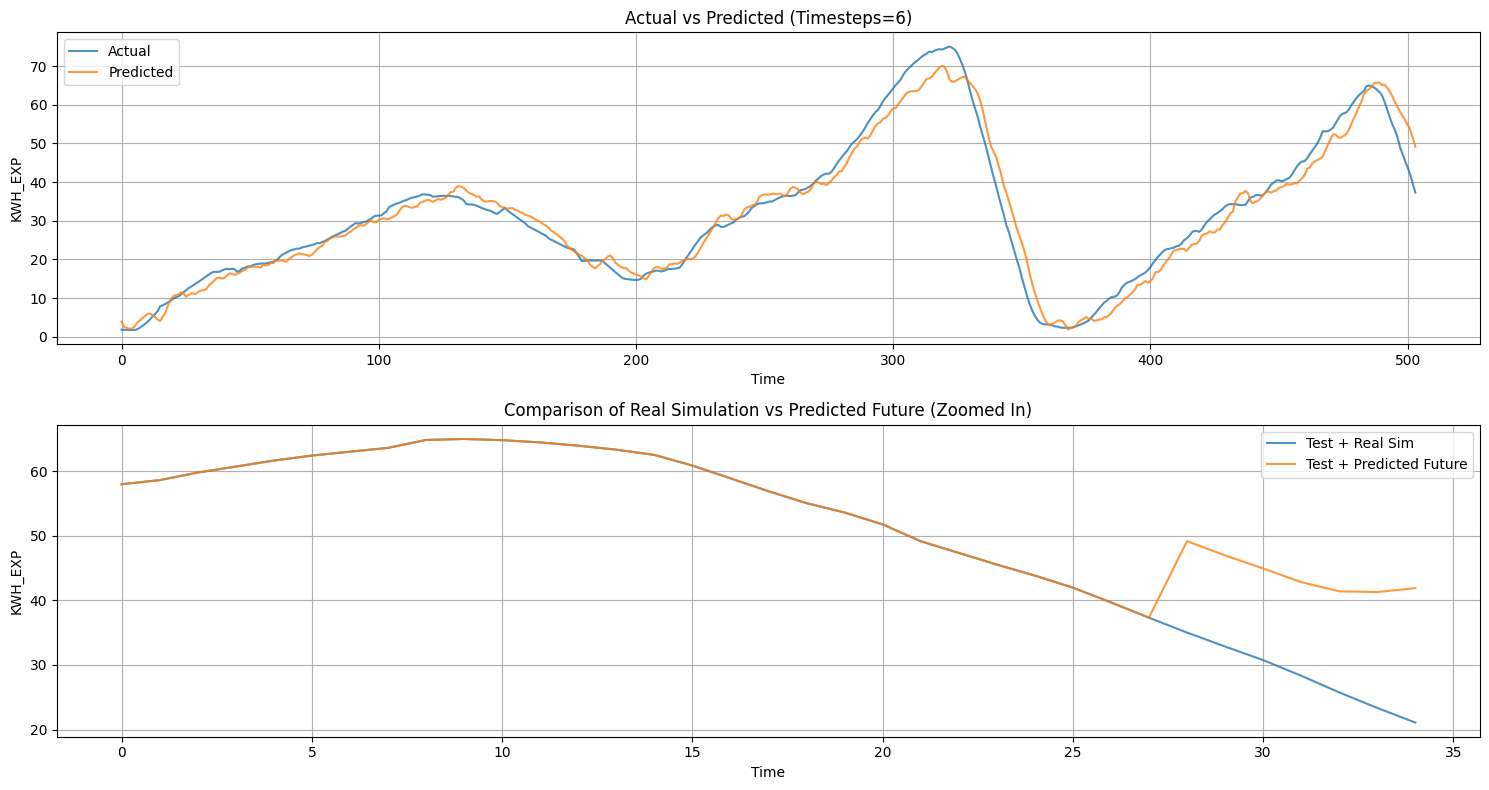


Metrics for timesteps=6:
MSE: 11.7807
R²: 0.9634
MAPE: 0.1221
MAE: 2.6224
Training time for timesteps = 6: 16.42 seconds

Training model with selected features and timesteps = 7
Epoch 24: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
Results saved to lstm_timestep_7_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


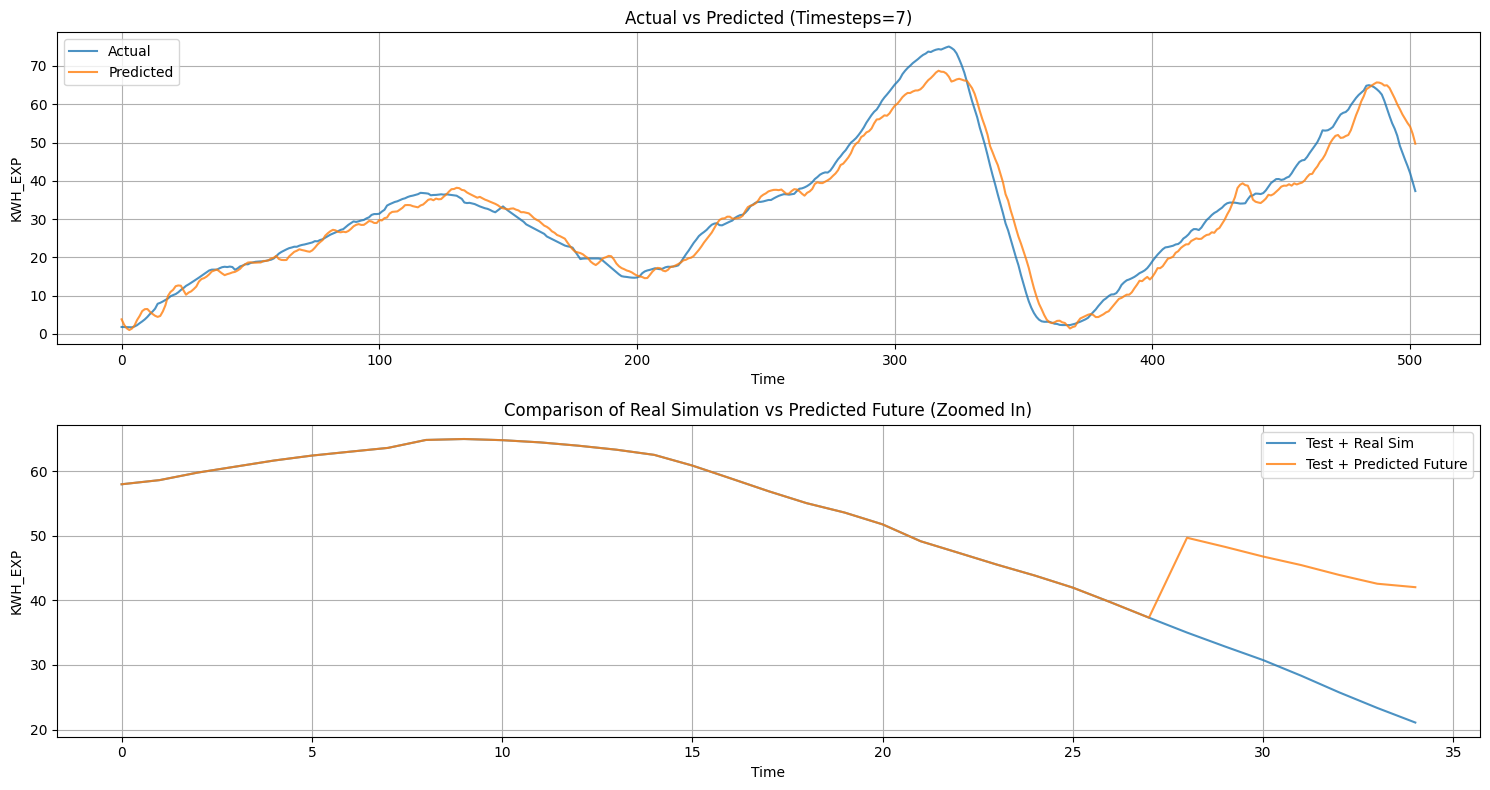


Metrics for timesteps=7:
MSE: 12.7029
R²: 0.9604
MAPE: 0.1195
MAE: 2.7042
Training time for timesteps = 7: 17.55 seconds
Total training execution time: 110.88 seconds


In [30]:
# Integrate with existing training scheme
total_training_start_time = time.time()
for ts in timesteps_list:
    print(f"\nTraining model with selected features and timesteps = {ts}")
    training_start_time = time.time()
    train_and_plot_lstm(train_scaled_features, train_scaled_target.ravel(), test_scaled_features, test_scaled_target.ravel(), ts, real_sim)
    training_end_time = time.time()
    print(f"Training time for timesteps = {ts}: {training_end_time - training_start_time:.2f} seconds")

total_training_end_time = time.time()
print(f"Total training execution time: {total_training_end_time - total_training_start_time:.2f} seconds")